In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats

In [51]:
# testing stats.kendalltau function
tau, _ = stats.kendalltau([3,1,0,2,4], [3,1,0,4,2])
print(tau)
tau, _ = stats.kendalltau([1,2,3,4,5], [1,2,3,5,4])
print(tau)
a = [0.5, 0.7, 0.2, 0.8, 0]
b = [0.6, 0.9, 0, 1, 0.4]
tau, _ = stats.kendalltau(a, b)
print(tau)

0.39999999999999997
0.7999999999999999
0.7999999999999999


In [46]:
mu = 0.0 #zero-mean
sigma_u = 1.0
sigma_v = 1.0
sigma = [0, 0.2, 0.4, 0.6, 0.8, 1] 

# Generate U, V from the Gaussian distribution
D = 2 #dimension
N = 10 #nbr of users
M = 10 #nbr of movies
alpha_vals = [1, 3, 10, 30, 100] #[1,5,10,50,100]
M_vals = [M*alpha for alpha in alpha_vals]
k_best = 10 # 
nb_iter = 1000 #100

In [47]:
#generate matrices U, V and R from Gauss. distributions

def generate_U_V_R(s, alpha):
    U = np.random.normal(mu, sigma_u, size=(D,N))
    V = np.random.normal(mu, sigma_v, size=(D,M*alpha))
    noise = np.random.normal(mu, s, size=(N,M*alpha)) 
    R = np.matmul(U.T,V) +noise
    return U, V, R

In [48]:
#map values to discrete ratings 

def condition(x):
    if x<-2:
        return 1
    elif x>=-2 and x<=-0.5:
        return 2
    elif x>-0.5 and x<=0.5:
        return 3
    elif x>0.5 and x<=2:
        return 4
    else:
        return 5

In [49]:
#compute similarity list of matrix U for a given user i

def similarity_list(U, user_i): # add user_i to the sim_fn
    df_U = pd.DataFrame(U)
    sim_array= cosine_similarity(df_U)[user_i] # for user i, i=0
    df_U['similarity_u1']= sim_array.tolist()
    df_U= df_U.sort_values(by= 'similarity_u1', ascending= False)
    user1_sim_list= df_U.index
    return user1_sim_list, sim_array

In [50]:
#compute kendalltau ranking similarity of 2 ranking lists for k_best rankings

def ranking_similarity(u1_list_U, u1_list_R, k_best):
    tau, p_value = stats.kendalltau(u1_list_U[:k_best], u1_list_R[:k_best])
    return tau


In [52]:
#compute average of kendalltau similarity for all users for given matrices U and R

def sim_avg_users(A, B):
    sum_similarities= 0
    for user_i in range(N):
        _, similarity_list_A = similarity_list(A, user_i)
        _, similarity_list_B = similarity_list(B, user_i)
        # print("user: ", user_i, "\n similarity U:\n", similarity_list_U, "\n similarity U_svd:\n", similarity_list_R)
        kd_tau = ranking_similarity(similarity_list_A, similarity_list_B, k_best)
        # print("kendall tau:", kd_tau)
        sum_similarities+= kd_tau
    return sum_similarities/N    
        

In [53]:
#compute averaged similarities for different values of M and sigma

np.random.seed(0)
data= []
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            U, V, R= generate_U_V_R(s, alpha)
            # print(U)
            # print(V)
            # print(R)
            similarities= sim_avg_users(U.T, R)
            # print(similarities)
            row= [M*alpha, s, similarities]
            data.append(row)

In [54]:
df = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df_res= df.groupby(by=['M','sigma']).mean()
df_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
10,0.935347,0.872547,0.806631,0.733747,0.684516,0.626156
30,0.962547,0.917756,0.868636,0.820938,0.781036,0.738036
100,0.979951,0.943938,0.902360,0.864653,0.836093,0.809467
300,0.988316,0.955831,0.919364,0.888409,0.863618,0.837711
1000,0.993329,0.961107,0.926200,0.896742,0.875133,0.856871


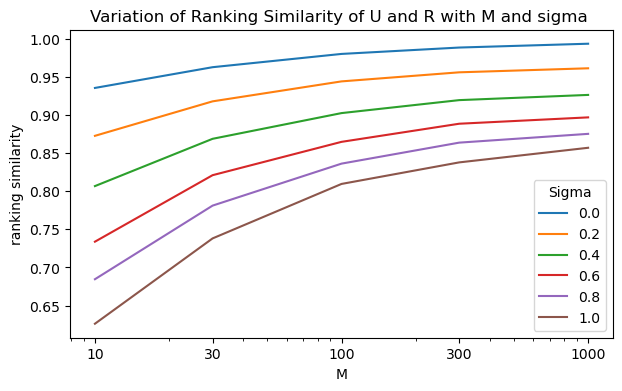

In [55]:
fig, ax = plt.subplots(figsize=(7,4))
df_res['sim_U_R'].unstack().plot(ax=ax)
plt.legend(title= 'Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and R with M and sigma ')
plt.xscale('log')
plt.xticks(M_vals, M_vals)
plt.xlabel('M')
plt.ylabel('ranking similarity')

plt.show()

# SVD

In [56]:
#compute averaged similarities for matrices U_svd and U for different values of M and sigma

np.random.seed(0)
data= []
for s in sigma:
    for alpha in alpha_vals:
        for k in range(nb_iter):
            U, V, R = generate_U_V_R(s, alpha)
            # print("U\n", U)
            # print("V\n", V)
            # print("R\n", R)
            U_svd, D_svd, VT_svd = np.linalg.svd(R, full_matrices=False)
            # print("U_svd\n", U_svd)
            # print("D_svd\n", D_svd)
            # print("V_svd\n", VT_svd.T)
            # print("U_svd . D_svd\n", np.dot(U_svd, np.diag(D_svd)))
            # print("U_svd . D_svd\n", U_svd*D_svd)
            similarities= sim_avg_users(U.T, U_svd[:,:D])
            row= [M*alpha, s, similarities]
            data.append(row)
# print values of D : diagonal values 

In [57]:
df2 = pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
df2_res= df2.groupby(by=['M','sigma']).mean()
df2_res['sim_U_R'].unstack()

sigma,0.0,0.2,0.4,0.6,0.8,1.0
M,,,,,,
10,0.927569,0.876507,0.818391,0.746622,0.692920,0.630093
30,0.928711,0.902458,0.874213,0.841360,0.806738,0.769920
100,0.928760,0.914653,0.900258,0.882658,0.863449,0.846089
300,0.928356,0.918951,0.912160,0.904800,0.895062,0.882338
1000,0.930036,0.923391,0.922000,0.916902,0.911884,0.906440


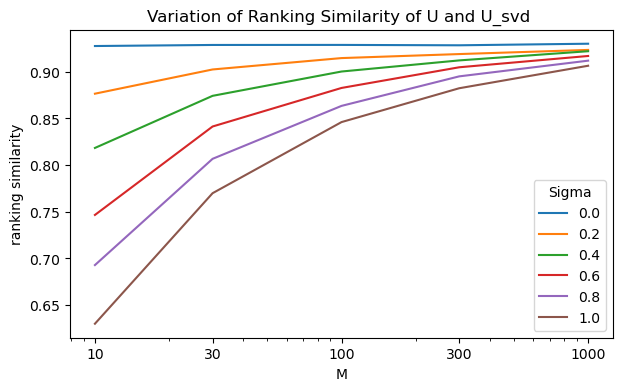

In [58]:
fig, ax = plt.subplots(figsize=(7,4))
df2_res['sim_U_R'].unstack().plot(ax=ax)
plt.legend(title= 'Sigma', loc='lower right')
plt.title('Variation of Ranking Similarity of U and U_svd ')
plt.xscale('log')
plt.xticks(M_vals, M_vals)
plt.xlabel('M')
plt.ylabel('ranking similarity')

plt.show()

# Truncated SVD

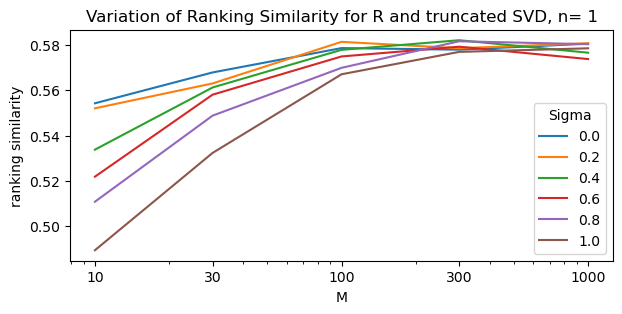

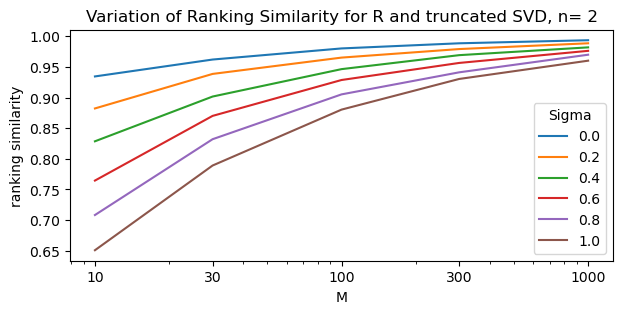

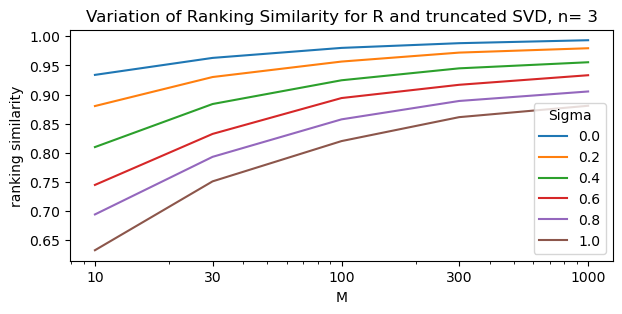

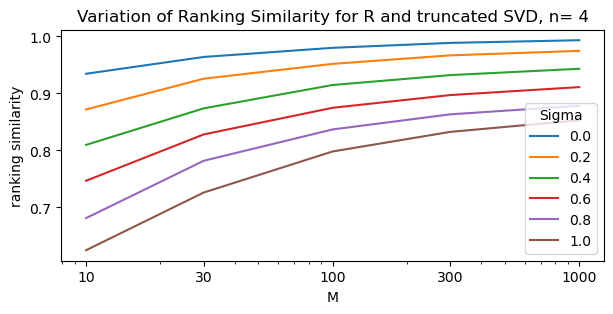

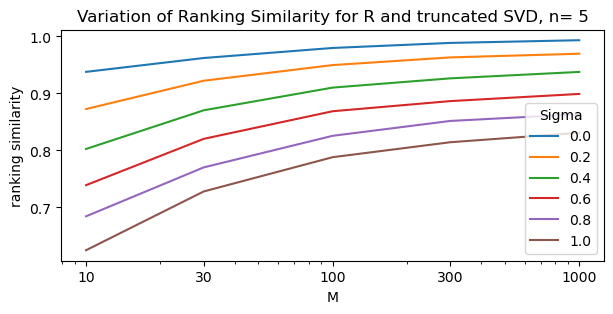

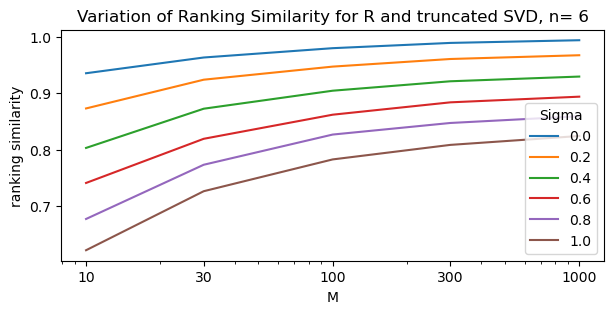

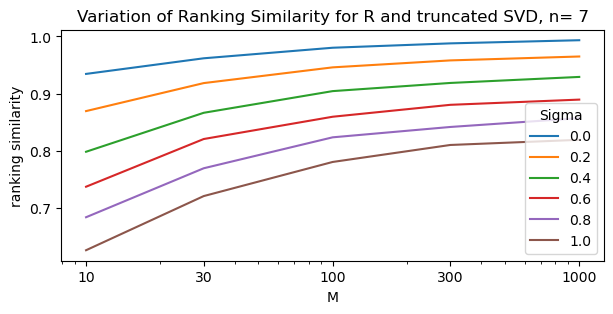

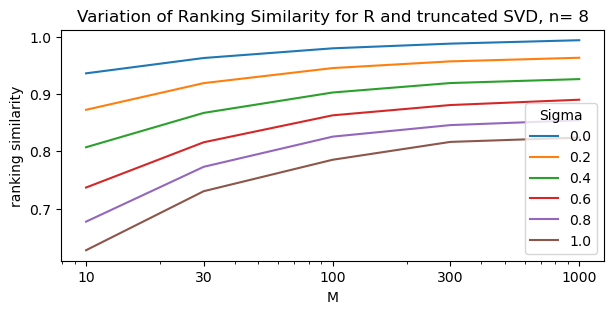

KeyboardInterrupt: 

In [60]:
#compute averaged similarities for matrices R and transformed matrix trun_svd
#for different values of M and sigma and 

for nb_components in range(1,M,1):
    data= []
    for s in sigma:
        for alpha in alpha_vals:
            for k in range(nb_iter):
                U, V, R = generate_U_V_R(s, alpha)
                trun_svd = TruncatedSVD(n_components = nb_components).fit_transform(R)
                similarities= sim_avg_users(U.T, trun_svd)
                row= [M*alpha, s, similarities]
                data.append(row)
    
    
    df= pd.DataFrame(data, columns=['M','sigma','sim_U_R'])
    df_res= df.groupby(by=['M','sigma']).mean()
    df_res['sim_U_R'].unstack()
    
    fig, ax = plt.subplots(figsize=(7,3))
    df_res['sim_U_R'].unstack().plot(ax=ax)
    plt.legend(title= 'Sigma', loc='lower right')
    plt.title('Variation of Ranking Similarity for R and truncated SVD, n= {}'.format(nb_components) )
    plt.xscale('log')
    plt.xticks(M_vals, M_vals)
    plt.xlabel('M')
    plt.ylabel('ranking similarity')
    plt.show()